In [60]:
import scipy
import scipy.io
from scipy.io import savemat
from scipy import special
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import math
import os
import functools

In [61]:
file_oi = "Ric_triTest.mat"#"BIC_triTest.mat"#"NESMA_cropped_slice5.mat"
folder_oi = "BIC_tests"#"BIC_tests"#"BLSA_1742_04_MCIAD_m41"
specific_name = 'Ric_triTest'#"BIC_triTest"#'slice_oi' - this is important if the data strux has an internal name

output_folder = "ExperimentalSets_Rician"

try:
    brain_data = scipy.io.loadmat(os.getcwd() + f'\\MB_References\\{folder_oi}\\{file_oi}')
except:
    brain_data = scipy.io.loadmat(os.getcwd() + f'/MB_References/{folder_oi}/{file_oi}')
I_raw = brain_data[specific_name]

n_vert, n_hori, n_elements_brain = I_raw.shape

t_increment_brain = 11.3

TDATA = np.linspace(t_increment_brain, (n_elements_brain)*(t_increment_brain), n_elements_brain)



In [62]:
def G_biX_Ric(t, con_1, con_2, tau_1, tau_2, sigma): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    alpha=(signal/(2*sigma))**2
    Expectation = sigma*np.sqrt(np.pi/2)*((1+2*alpha)*special.ive(0, alpha) + 2*alpha*special.ive(1,alpha))
    return Expectation

def G_moX_Ric(t, con, tau, sigma): 
    signal = con*np.exp(-t/tau)
    alpha=(signal/(2*sigma))**2
    Expectation = sigma*np.sqrt(np.pi/2)*((1+2*alpha)*special.ive(0, alpha) + 2*alpha*special.ive(1,alpha))
    return Expectation 

In [63]:
def calculate_BIC(RSS, popt):#, sigma):

    # BIC = 1/len(TDATA) * (RSS + np.log(len(TDATA)) * len(popt)*(sigma)**2)
    BIC = len(TDATA) * np.log(RSS/len(TDATA)) + (len(popt)+1)*np.log(len(TDATA))

    return BIC

def calculate_RSS(data, popt, func):
    est_curve = func(TDATA, *popt)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def normalize_brain(I_data):
    n_vert, n_hori, n_elem = I_data.shape
    I_normalized = np.zeros(I_data.shape)
    for i_vert in range(n_vert):
        for i_hori in range(n_hori):
            data = I_data[i_vert,i_hori,:]
            if data[0]>0:
                data_normalized = data/(data[0])
            else:
                data_normalized = np.zeros(n_elements_brain)
            I_normalized[i_vert,i_hori,:] = data_normalized
    return I_normalized

def Rician_sigma(data):
    noise_floor = np.mean(data[-3:])
    sigma = np.sqrt(2/np.pi)*noise_floor
    return sigma

def get_upperBound(func, sig_init = 1):
    #These bounds were chosen to match the simulated data while also being restrictive enough
    #This provides a little extra space as the hard bounds would be [1,1,50,300]
    f_name = func.__name__
       
    if 'biX' in f_name:
        init_p0 = [0.75*sig_init, 2*sig_init, 80, 300]
    elif 'moX' in f_name:
        init_p0 = [1.5*sig_init, 300]
    else:
        raise Exception("Not a valid function: " + f_name)

    return init_p0

def get_param_p0(func, sig_init = 1):
    f_name = func.__name__
       
    if 'biX' in f_name:

        init_p0 = [sig_init*0.2, sig_init*0.8, 20, 80]
    elif 'moX' in f_name:

        init_p0 = [sig_init, 20]
    else:
        raise Exception("Not a valid function: " + f_name)

    return init_p0

In [64]:
def BIC_filter(data):

    biX_upperBounds = get_upperBound(G_biX_Ric)
    moX_upperBounds = get_upperBound(G_moX_Ric)

    biX_lowerBounds = np.zeros(len(biX_upperBounds))
    moX_lowerBounds = np.zeros(len(moX_upperBounds))

    biX_initP = get_param_p0(G_biX_Ric, sig_init = data[0])
    moX_initP = get_param_p0(G_moX_Ric, sig_init = data[0])

    sigma_est = Rician_sigma(data)
    G_biX_params, _ = curve_fit(functools.partial(G_biX_Ric, sigma = sigma_est), TDATA, data, bounds = (biX_lowerBounds, biX_upperBounds), p0=biX_initP, max_nfev = 4000)
    G_moX_params, _ = curve_fit(functools.partial(G_moX_Ric, sigma = sigma_est), TDATA, data, bounds = (moX_lowerBounds, moX_upperBounds), p0=moX_initP, max_nfev = 4000)

    G_biX_params = np.append(G_biX_params, sigma_est)
    G_moX_params = np.append(G_moX_params, sigma_est)

    RSS_biX = calculate_RSS(data, G_biX_params, G_biX_Ric)
    RSS_moX = calculate_RSS(data, G_moX_params, G_moX_Ric)

    BIC_G_biX = calculate_BIC(RSS_biX, G_biX_params)#, sigma_est)
    BIC_G_moX = calculate_BIC(RSS_moX, G_moX_params)#, sigma_est)

    return BIC_G_moX < BIC_G_biX, G_moX_params, BIC_G_moX

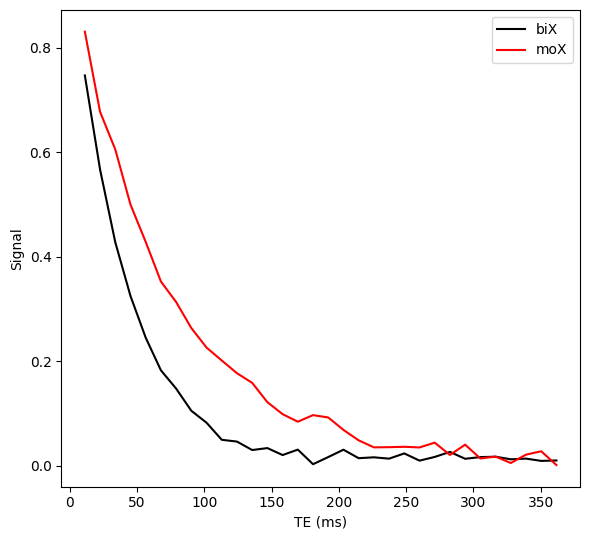

In [65]:
fig, ax = plt.subplots(1,1,figsize=(6,5.5),tight_layout=True)
plt.plot(TDATA, I_raw[0,0,:], color = 'k', label = 'biX')
plt.plot(TDATA, I_raw[n_vert//2,n_hori//2,:], color = 'r', label = 'moX')
plt.xlabel('TE (ms)')
plt.ylabel('Signal')
plt.legend()

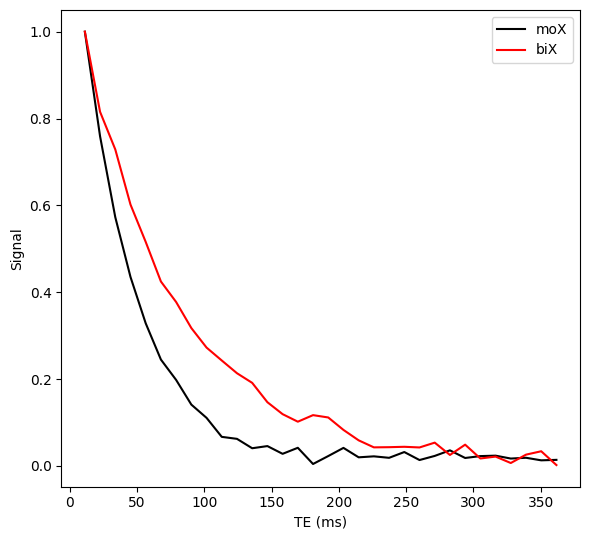

In [66]:
I_norm = normalize_brain(I_raw)

fig, ax = plt.subplots(1,1,figsize=(6,5.5),tight_layout=True)
plt.plot(TDATA, I_norm[0,0,:], color = 'k', label = 'moX')
plt.plot(TDATA, I_norm[n_vert//2,n_hori//2,:], color = 'r', label = 'biX')
plt.xlabel('TE (ms)')
plt.ylabel('Signal')
plt.legend()

In [67]:
#### Data Set Up
biX_data = I_norm[n_vert//2,n_hori//2,:]
moX_data = I_norm[0,0,:]

biX_upperBounds = get_upperBound(G_biX_Ric)
moX_upperBounds = get_upperBound(G_moX_Ric)

biX_lowerBounds = np.zeros(len(biX_upperBounds))
moX_lowerBounds = np.zeros(len(moX_upperBounds))

#### BiX Data Specific Results
biX_initP = get_param_p0(G_biX_Ric, sig_init = biX_data[0])
moX_initP = get_param_p0(G_moX_Ric, sig_init = biX_data[0])

sigma_est = Rician_sigma(biX_data)
G_biX_params, _ = curve_fit(functools.partial(G_biX_Ric, sigma = sigma_est), TDATA, biX_data, bounds = (biX_lowerBounds, biX_upperBounds), p0=biX_initP, max_nfev = 4000)
G_moX_params, _ = curve_fit(functools.partial(G_moX_Ric, sigma = sigma_est), TDATA, biX_data, bounds = (moX_lowerBounds, moX_upperBounds), p0=moX_initP, max_nfev = 4000)

G_biX_params_biXDat = np.append(G_biX_params, sigma_est)
G_moX_params_biXDat = np.append(G_moX_params, sigma_est)

RSS_biX_biXDat = calculate_RSS(biX_data, G_biX_params_biXDat, G_biX_Ric)
RSS_moX_biXDat = calculate_RSS(moX_data, G_moX_params_biXDat, G_moX_Ric)

print(f"BiX Data-------------")
print(f"moX Fit  = {G_moX_params}")
print(f"biX Fit  = {G_biX_params}")
print(f"moX RSS = {RSS_moX_biXDat}")
print(f"biX RSS = {RSS_biX_biXDat}")

#### BiX Data Specific Results
biX_initP = get_param_p0(G_biX_Ric, sig_init = moX_data[0])
moX_initP = get_param_p0(G_moX_Ric, sig_init = moX_data[0])

sigma_est = Rician_sigma(moX_data)
G_biX_params, _ = curve_fit(functools.partial(G_biX_Ric, sigma = sigma_est), TDATA, moX_data, bounds = (biX_lowerBounds, biX_upperBounds), p0=biX_initP, max_nfev = 4000)
G_moX_params, _ = curve_fit(functools.partial(G_moX_Ric, sigma = sigma_est), TDATA, moX_data, bounds = (moX_lowerBounds, moX_upperBounds), p0=moX_initP, max_nfev = 4000)

G_biX_params_moXDat = np.append(G_biX_params, sigma_est)
G_moX_params_moXDat = np.append(G_moX_params, sigma_est)

RSS_biX_moXDat = calculate_RSS(biX_data, G_biX_params_moXDat, G_biX_Ric)
RSS_moX_moXDat = calculate_RSS(moX_data, G_moX_params_moXDat, G_moX_Ric)

print(f"\nBiX Data-------------")
print(f"moX Fit  = {G_moX_params}")
print(f"biX Fit  = {G_biX_params}")
print(f"moX RSS = {RSS_moX_moXDat}")
print(f"biX RSS = {RSS_biX_moXDat}")


BiX Data-------------
moX Fit  = [ 1.14337505 72.02384511]
biX Fit  = [ 0.23034214  0.95826824 32.73236497 79.50692186]
moX RSS = 0.3408350445214676
biX RSS = 0.004858545381078647

BiX Data-------------
moX Fit  = [ 1.32259414 40.55290532]
biX Fit  = [ 0.52261101  0.8000321  40.06806608 40.86888865]
moX RSS = 0.002652867526282813
biX RSS = 0.34042565370503886


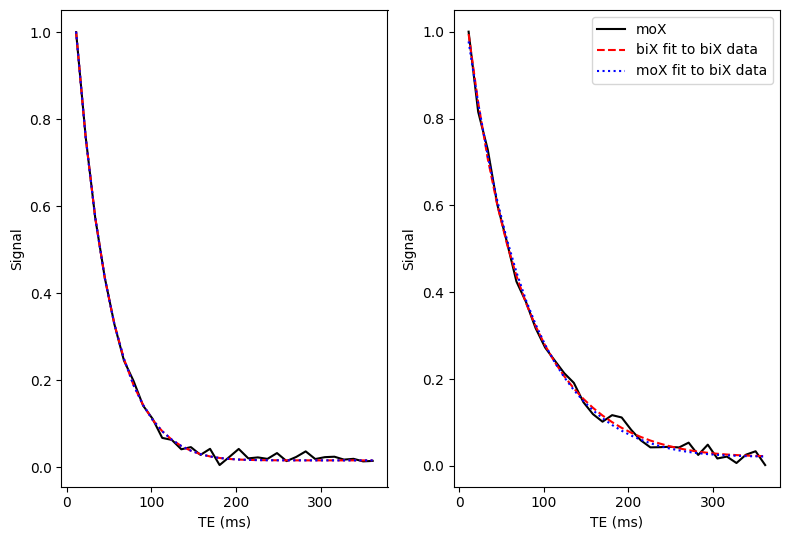

In [68]:
fig, ax = plt.subplots(1,2,figsize=(8,5.5),tight_layout=True)
### moX Section
ax[0].plot(TDATA, moX_data, color = 'k', label = 'moX')
ax[0].plot(TDATA, G_biX_Ric(TDATA, *G_biX_params_moXDat), color = 'r', ls = '--', label = 'biX fit to moX data')
ax[0].plot(TDATA, G_moX_Ric(TDATA, *G_moX_params_moXDat), color = 'b', ls = ':', label = 'moX fit to moX data')
ax[0].set_xlabel('TE (ms)')
ax[0].set_ylabel('Signal')

### biX Section
ax[1].plot(TDATA, biX_data, color = 'k', label = 'moX')
ax[1].plot(TDATA, G_biX_Ric(TDATA, *G_biX_params_biXDat), color = 'r', ls = '--', label = 'biX fit to biX data')
ax[1].plot(TDATA, G_moX_Ric(TDATA, *G_moX_params_biXDat), color = 'b', ls = ':', label = 'moX fit to biX data')
ax[1].set_xlabel('TE (ms)')
ax[1].set_ylabel('Signal')
plt.legend()

In [69]:
BIC_mask = np.zeros((n_vert,n_hori))

for i_vert in range(n_vert):
    for i_hori in range(n_hori):
        BIC_mask[i_vert,i_hori], _, _ = BIC_filter(I_raw[i_vert,i_hori,:])

Text(0.8, 0, 'moX')

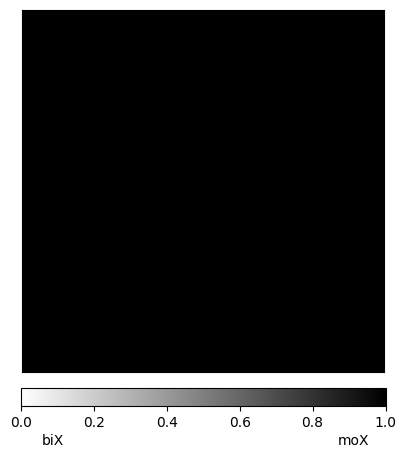

In [70]:
fig, ax = plt.subplots(1,1,figsize=(5,4.5),tight_layout=True)
triangle = plt.imshow(BIC_mask, vmin = 0, vmax = 1, cmap = 'binary')
ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
fig.colorbar(triangle, ax=ax, fraction=0.046, pad=0.04, location = 'bottom')
fig.text(0.2,0,'biX', ha = 'center')
fig.text(0.8,0,'moX', ha = 'center')